In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Probar con una función cualquiera

In [ ]:
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

print(Z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Datos de la simulación

En la simulacion existen $n$ características que describen los diferentes temas de los que puede tratar un post, como `tecnología`, `ciencia`, `medio ambiente`, `política`, etc. Cada post en la red social tiene un vector $v$ de $n$ dimensiones con valores $v_i \in [0, 1]$ que indica que tan relevante es el tema $i$ en el post.
También, de la simulación se extrae para cada característica, tres indicadores importantes. Para una publicación con tema $i$ se extrae:

- Porcentaje de la red que le da likes a una publicación donde el tema $i$ sea relevante.
- Porcentaje de la red que le da dislikes a una publicación donde el tema $i$ sea relevante.
- Porcentaje de la red que comparte una publicación donde el tema $i$ sea relevante.

Por tanto, podemos crear una matrix $C{n,3}$ donde $C_{i,j}$ indica que porcentaje de la red tuvo la reacción $j$ en posts donde el tema $i$ es relevante.

## Función objetivo

El objectivo es entonces encontrar el vector $v$ tal que tenga la mejor combinación de relevancias por cada característica y nos dé el mayor crecimiento en la red. Como el impacto de una post de un tema $i$ se mide por los 3 índices expuestos anteriormente (`likes`, `dislikes`, `shared`), entonces necesitamos un valor que indique cuan relevante es este índice para un post. Sea $\alpha, \beta, \lambda \in [-1, 1]$ los respectivos indices de relevancia, en donde $-1$ afecta muy negativamente al post y $1$ afecta muy positivamente al post.

Por otro lado para medir el impacto de una publicación en la red esta se podría calcular como:
$$
I(v) = \alpha g_1(v) + \beta g_2(v) + \lambda g_3(v)
$$
donde $g_1(v), g_1(v)$ y $g_1(v)$ indican cuanto afectan los indices de crecimiento respectivamente entre todos los temas.

La forma de calcular las 3 funciones son la misma, solo que se separan en funciones diferentes para mejor comprensión. Para esto hacemos uso de la función exponencial para recompenzar las a los valores mas grandes de $x$. Entonces podemos definir la función $g_1(v)$ que indica cuanto ... como:

$$
g_1(v) = v_1 \alpha e ^ {\sum_{i=1}^{n} C_{i,1}} 
$$

Entonces la función en su totalidad la podemos expresar como:
$$
I(v) = \alpha g_1(v) + \beta g_2(v) + \lambda g_3(v) = v_1 \alpha e ^ {\sum_{i=1}^{n} C_{i,1}} + v_2 \beta e ^ {\sum_{i=1}^{n} C_{i,2}} + v_3 \lambda e ^ {\sum_{i=1}^{n} C_{i,3}}
$$

Si definimos el vector $z = [\alpha, \beta, \lambda]$ entonces la función quedaría:
$$
I(v) = \sum_{j=1}^{3} z_j v_i  e ^ {\sum_{i=1}^{n} C_{i,j}}
$$

Ahora bien, como queremos hallar el vector $x$ tal que maximize el impacto en la red entonces tenemos que optimizar la funcion $I$ para calcular el máximo:
$$
\max I(v) = \max \sum_{j=1}^{3} z_j v_i e ^ {\sum_{i=1}^{n} C_{i,j}}
$$

In [8]:
N = 2
C = np.array([
    [0.3, 0.1, 0.8],
    [0.1, 0.6, 0.5],
])

index_relevance = [0.7, -0.6, 0.5] # alpha, beta, lambda

def func_obj(x):
    fitness = 0
    for j in range(3):
        v = 0
        for i in range(N):
            v += C[i][j]
        fitness += x[i] * index_relevance[j] * np.exp(v) 
    return fitness 

In [9]:
print(func_obj([2, 4]))

6.682695990704902


## Imprimir la función

Max value:  <built-in method max of numpy.ndarray object at 0x00000256D0ABC750>


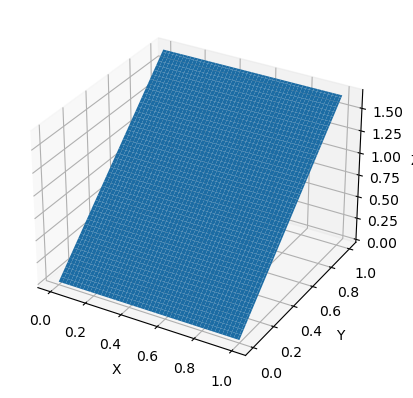

In [10]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = func_obj([X, Y])

print('Max value: ', Z.max)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Optimización por Enjambre de Partículas

In [1]:
import sys
import threading
import time
import types
from abc import ABC, abstractmethod
from typing import Any, Callable, List, Optional


class Evaluation:
    def __init__(
        self,
        mh_name: str,
        solutions: List[Any],
        values: List[Any],
        total_evals: int,
        total_time: float,
        fail_msg: Optional[str],
    ):
        self.mh_name = mh_name
        self.solutions = solutions
        self.values = values
        self.iters = len(self.solutions)
        self.best_result = None if not self.solutions else self.solutions[-1]
        self.total_evals = total_evals
        self.total_time = total_time
        self.success = fail_msg is None
        self.fail_msg = fail_msg

    def __repr__(self) -> str:
        ans = (
            f"Evaluation of {self.mh_name}:\n"
            f"  best result --------------- {self.best_result}\n"
            f"  success ------------------- {self.success}\n"
            f"  iters --------------------- {self.iters}\n"
            f"  evals --------------------- {self.total_evals}\n"
            f"  time ---------------------- {self.total_time}\n"
        )
        if self.iters:
            ans += (
                f"  approx. evals per iter ---- {self.total_evals / self.iters}\n"
                f"  approx. iter time --------- {self.total_time / self.iters}\n"
            )
        if not self.success:
            ans += f"  fail reason: '{self.fail_msg}'\n"
        return ans

    def __str__(self) -> str:
        return repr(self)


class MetaHeuristic(ABC):
    @abstractmethod
    def solve(self, obj_fuc: Callable, *args, **kwargs) -> Any:
        """Solves a problem given an objective function"""
        raise NotImplementedError()

    def on_new_solution(self, sol: Any, val: Any):
        """This function is called every time a new solution is found"""

    def evaluate(
        self,
        obj_func: Callable,
        max_evals: Optional[int] = None,
        max_iters: Optional[int] = None,
        max_time: Optional[float] = None,
        check_every: float = 0.00001,
        verbose: bool = True,
        *args,
        **kwargs,
    ) -> Evaluation:
        if verbose:
            print(f"Evaluating {self.__class__.__name__}", flush=True)
        evals = 0
        solutions = []
        values = []
        fail_msg = None

        def _obj_func(*args, **kwargs):
            nonlocal evals
            nonlocal fail_msg

            if fail_msg is not None:
                sys.exit(0)

            if max_evals is not None and evals == max_evals:
                fail_msg = "Obj. function max evaluation exceeded."
                sys.exit(0)

            evals += 1
            return obj_func(*args, **kwargs)

        def _solve_func():
            nonlocal solutions
            nonlocal values
            nonlocal fail_msg
            sol = self.solve(_obj_func, *args, **kwargs)
            if isinstance(sol, types.GeneratorType):
                for s, v in sol:
                    if verbose:
                        print(" " * 100, end="\r")
                        print(
                            f"{time.time() - t0:.3f}s - Last value: {v} - Last solution: {s}",
                            end="\r",
                            flush=True,
                        )
                    self.on_new_solution(s, v)
                    solutions.append(s)
                    values.append(v)
                    if max_iters is not None and len(solutions) == max_iters:
                        fail_msg = "Max iterations exceeded."
                        sys.exit(0)
            elif isinstance(sol, tuple) and len(sol) == 2:
                solutions = [sol[0]]
                values = [sol[1]]
            else:
                raise ValueError(
                    "The 'solve' function must return tuples of size 2: (solution, value)."
                )
            print()

        proc = threading.Thread(target=_solve_func)

        t0 = time.time()
        proc.start()
        if max_time is not None:
            t1 = time.time()
            failed = True
            while t1 - t0 < max_time:
                if not proc.is_alive():
                    failed = False
                    break
                time.sleep(check_every)
                t1 = time.time()
            if failed:
                fail_msg = "Max time exceeded."
        else:
            proc.join()
            t1 = time.time()

        total_time = t1 - t0

        res = Evaluation(
            self.__class__.__name__,
            solutions=solutions,
            values=values,
            total_evals=evals,
            total_time=total_time,
            fail_msg=fail_msg,
        )
        return res


## Probando la metaheuristica

In [2]:
from __future__ import annotations

import logging
import random
from collections import namedtuple
from typing import Callable, Optional, Tuple

import numpy as np
from scipy.stats import cauchy


def _ensure_ndarray(func):
    def wrapper(x, *args, **kwargs):
        if isinstance(x, float):
            x = [x]
        x = np.array(x)
        return func(x, *args, **kwargs)

    return wrapper


def _reset_rngs(func):
    def wrapper(self: BBOB, *args, seed: Optional[int] = None, **kwargs):
        self.reset_rngs(seed=seed)
        return func(self, *args, **kwargs)

    return wrapper


class BBOBFunc:
    def __init__(
        self,
        name: str,
        dim: int,
        x_opt: np.ndarray,
        f_opt: float,
        func: Callable,
    ):
        self.name = name
        self.dim = dim
        self.x_opt = x_opt
        self.f_opt = f_opt
        self.func = func

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

    def __repr__(self) -> str:
        ans = f"BBOB {self.name} function instance:\n"
        ans += f"  dim:    {self.dim}\n"
        ans += f"  x_opt:  {self.x_opt}\n"
        ans += f"  f_opt:  {self.f_opt}"
        return ans

    def __str__(self) -> str:
        return repr(self)

    def _plot_1d(self, show: bool = True):
        import matplotlib.pyplot as plt

        X = np.linspace(-5, 5, 200)
        Y = [self.func(np.array([x])) for x in X]
        plt.plot(X, Y)
        plt.plot([self.x_opt], [self.f_opt], "ro")
        if show:
            plt.show()

    def _plot_2d(self, show: bool = True):
        import matplotlib.pyplot as plt

        x = np.linspace(-5, 5, 200)
        X, Y = np.meshgrid(x, x)
        Z = np.array([[self.func(np.array([x1, x2])) for x1 in x] for x2 in x])
        ax = plt.figure().add_subplot(projection="3d")
        min_loc = list(self.x_opt)
        min_loc.append(self.f_opt)
        ax.plot(*min_loc, "ro")
        ax.plot_surface(
            X, Y, Z, cmap="viridis_r", alpha=0.9, linewidth=0, edgecolor="none"
        )
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.tight_layout()
        if show:
            plt.show()

    def plot(self, show: bool = True):
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            logging.error(
                "Function plot failed. Matplotlib library not found. "
                "You can install it by doing: 'pip install matplotlib'."
            )
            return
        if self.dim == 1:
            self._plot_1d(show)
        elif self.dim == 2:
            self._plot_2d(show)
        else:
            raise ValueError("Can not plot functions where D > 2")


class BBOB:
    def __init__(self, seed=None):
        self.seed = seed
        self.np_rng = np.random.default_rng(seed)
        self.rng = random.Random(seed)

    def reset_rngs(self, seed: Optional[int] = None):
        seed = self.seed if seed is None else seed
        self.np_rng = np.random.default_rng(seed)
        self.rng = random.Random(seed)

    def _random_x_opt(self, dim, min_x=-5, max_x=5):
        return self.np_rng.random(dim) * (max_x - min_x) + min_x

    def _random_f_opt(self) -> float:
        val = round(cauchy.rvs(loc=0.0, scale=100, random_state=self.seed), 2)
        val = min(1_000, val)
        val = max(-1_000, val)
        return val

    def _get_vars(
        self, dim: Optional[int], min_dim: int = 1
    ) -> Tuple[int, np.ndarray, float]:
        if dim is None:
            dim = self.rng.randint(min_dim, 20)
        x_opt = self._random_x_opt(dim)
        f_opt = self._random_f_opt()

        return dim, x_opt, f_opt

    def _tosz_transf(self, x: np.ndarray) -> np.ndarray:
        x_c1 = x * np.where(x > 0, 10, 5.5)
        x_c2 = x * np.where(x > 0, 7.9, 3.1)
        non_zeros = np.abs(x) > 1e-5
        x_hat = np.log(np.abs(x) * non_zeros, where=non_zeros)
        return np.sign(x) * np.exp(x_hat + 0.049 * (np.sin(x_c1) + np.sin(x_c2)))

    def _tasy_transf(self, x: np.ndarray, beta: float) -> np.ndarray:
        D = x.shape[0]
        idx = np.where(x > 0)
        _x = x[idx]
        x[idx] = np.power(_x, np.sqrt(_x) * beta * idx / (D - 1) + 1)
        return x

    def _diag_matrix(self, alpha: float, D: int) -> np.ndarray:
        A = np.zeros((D, D))
        idx = np.diag_indices(D)
        A[idx] = alpha
        A[idx] = np.power(A[idx], 0.5 * np.arange(0, D) / (D - 1))
        return A

    def _f_pen(self, x: np.ndarray) -> float:
        return sum([max(0, abs(x_i) - 5) ** 2 for x_i in x])

    @_reset_rngs
    def sphere_func(
        self,
        dim: Optional[int] = None,
    ) -> BBOBFunc:
        D, x_opt, f_opt = self._get_vars(dim)

        @_ensure_ndarray
        def _func(x: np.ndarray) -> float:
            return float(np.linalg.norm(x - x_opt)) ** 2 + f_opt

        return BBOBFunc("sphere", D, x_opt, f_opt, _func)

    @_reset_rngs
    def ellipsodial_func(
        self,
        dim: Optional[int] = None,
    ) -> BBOBFunc:
        D, x_opt, f_opt = self._get_vars(dim)

        @_ensure_ndarray
        def _func(x: np.ndarray) -> float:
            z = self._tosz_transf(x - x_opt)
            ans = 0
            for i in range(D):
                ans += z[i] ** 2 * 10 ** (6 * i / D - 1)
            return ans + f_opt

        return BBOBFunc("ellipsodial", D, x_opt, f_opt, _func)

    @_reset_rngs
    def rastrigin_func(
        self,
        dim: Optional[int] = None,
    ) -> BBOBFunc:
        D, x_opt, f_opt = self._get_vars(dim, min_dim=2)

        assert D > 1, "dim value must be grater thatn 1 for this function"

        @_ensure_ndarray
        def _func(x: np.ndarray) -> float:
            A = self._diag_matrix(alpha=10, D=D)
            z = np.dot(
                A,
                self._tasy_transf(
                    self._tosz_transf(x - x_opt),
                    beta=0.2,
                ),
            )
            return (
                10 * (D - np.sum(np.cos(2 * np.pi * z)))
                + np.linalg.norm(z) ** 2
                + f_opt
            )

        return BBOBFunc("rastrigin", D, x_opt, f_opt, _func)

    @_reset_rngs
    def buche_rastrigin_func(
        self,
        dim: Optional[int] = None,
    ) -> BBOBFunc:
        D, x_opt, f_opt = self._get_vars(dim)

        assert D > 1, "dim value must be grater thatn 1 for this function"

        mask = np.zeros(D, dtype=bool)
        mask[np.arange(0, D, 2)] = True

        @_ensure_ndarray
        def _func(x: np.ndarray) -> float:
            s = np.array((D,))
            s.fill(10)
            s = np.power(s, np.arange(0, D) * 0.5 / (D - 1))
            s[mask] *= 10
            z = s * self._tosz_transf(x - x_opt)
            return (
                10 * (D - np.sum(np.cos(2 * np.pi * z)))
                + np.sum(z**2)
                + 100 * self._f_pen(x)
                + f_opt
            )

        return BBOBFunc("buche-rastrigin", D, x_opt, f_opt, _func)

    @_reset_rngs
    def linear_slpoe_func(
        self,
        dim: Optional[int] = None,
    ) -> BBOBFunc:
        D, _, f_opt = self._get_vars(dim)

        assert D > 1, "dim value must be grater thatn 1 for this function"

        x_opt = self.np_rng.random(D) - 0.5
        x_opt[x_opt >= 0] = 1
        x_opt[x_opt < 0] = -1
        x_opt *= 5

        mask = np.zeros(D, dtype=bool)
        mask[np.arange(0, D, 2)] = True

        @_ensure_ndarray
        def _func(x: np.ndarray) -> float:
            s = np.array((D,))
            s.fill(10)
            s = np.power(s, np.arange(0, D) / (D - 1))
            s *= np.sign(x_opt)
            s[mask] *= 10
            z = np.array([x[i] if x_opt[i] * x[i] < 25 else x_opt[i] for i in range(D)])
            return np.sum(5 * np.abs(s) - s * z) + f_opt

        return BBOBFunc("linear slope", D, x_opt, f_opt, _func)


In [3]:
def test_metaheuristic(
    mh: MetaHeuristic,
    max_evals: Optional[int] = None,
    max_iters: Optional[int] = None,
    max_time: Optional[float] = 5,
    *args,
    **kwargs,
):
    bbob = BBOB(seed=10)
    bbob_functions = [
        bbob.sphere_func(dim=2),
        bbob.ellipsodial_func(dim=2),
        bbob.rastrigin_func(dim=2),
        bbob.buche_rastrigin_func(dim=2),
        bbob.linear_slpoe_func(dim=2),
    ]

    for func in bbob_functions:
        print("\nTest\n")
        print(func, end="\n\n")
        ev = mh.evaluate(
            func.func,
            max_evals=max_evals,
            max_iters=max_iters,
            max_time=max_time,
            *args,
            **kwargs,
        )
        print(ev)

        print()
        print(f"Error: {abs(func.f_opt - func(ev.best_result))}")

        try:
            import matplotlib.pyplot as plt
            func.plot(show = False)
            sols = np.array(ev.solutions)
            values = np.array(ev.values)[..., None]
            points = np.hstack((sols, values))
            plt.plot(*list(points.T), '-o', color='blue')
            plt.show()
        except ImportError:
            pass

### Una metaheuristica de ejemplo

In [78]:
import abc
import random

# Particle Swarm Optimization
class PSO(MetaHeuristic, abc.ABC):
    def __init__(self) -> None:
        self.hpos = None
        super().__init__()
    
    class Particle:
        def __init__(self, pos, speed, inertia=0.5, cognitive_coeff=0.6, social_coeff=0.6) -> None:
            assert len(pos) == len(speed), "The particle position and speed must be the same length"
            self.pos = pos
            self.speed = speed
            self.best_pos = pos
            self.dim = len(pos)
            
            self.inertia = inertia
            self.cog_coeff = cognitive_coeff
            self.soc_coeff = social_coeff

        def upd_speed(self, global_best):
                rp = random.random()
                rg = random.random()
                self.speed = self.inertia*self.speed + self.cog_coeff*rp*(self.best_pos-self.pos) + self.soc_coeff*rg*(global_best - self.pos)
    
        def upd_pos(self):
            self.pos += self.speed            

        def upd_best_pos(self):
            self.best_pos = self.pos
            
        def __str__(self) -> str:
            return str(self.pos)
        
    
    def stop_condition(self, particles, t) -> bool:
        if t < 1000:
            return False
        
        npos = np.array([p.pos for p in particles])
        if self.hpos is None:
            self.hpos = npos
            return False
        
        diff = npos - self.hpos
        self.hpos = npos
        for i in diff:
            if not all(map(lambda s: abs(s) <= 0.0000001, i)):
                return False
                
        return True    
        
    def get_init_pop(self, sol_dim, pop_size):        
        init_pop = [
            PSO.Particle(
                pos=np.array([random.uniform(-5, 5) for _ in range(sol_dim)]),
                speed=np.zeros(sol_dim)
            )
            for i in range(pop_size)
        ]
        return init_pop
    
    def is_best_sol(self, x, y, obj_func: Callable):
        if obj_func(x) < obj_func(y):
            return True
        else:
            return False
    
    def solve(self, obj_func: Callable, sol_dim, pop_size=random.randint(6, 10)):
        # generate the initial population
        sols = self.get_init_pop(sol_dim, pop_size)
        
        # search the best position
        global_best = None        
        for sol in sols:
            if global_best is None or self.is_best_sol(sol.pos, global_best, obj_func):
                global_best = sol.pos
        
        t = 0
        while(not self.stop_condition(sols, t)):
            print(f'\n======== Iteracion {t} =========')
            print(f'Best sol: {global_best}')
            print(f'Cand sol: {[x.pos for x in sols]}')
            
            for p in sols:
                p.upd_speed(global_best)
                p.upd_pos()
                if self.is_best_sol(p.best_pos, p.pos, obj_func):
                    p.upd_best_pos()
                if self.is_best_sol(p.best_pos, global_best, obj_func):
                    global_best = p.best_pos
            t += 1
                    
        return global_best

In [4]:
# Create an instance of BBOB. You can specify a seed for reproducibility.
bbob = BBOB(seed=10)
br_func = bbob.buche_rastrigin_func(dim=2)

print('============== real ==================')
print(f"Optimal x is: {br_func.x_opt}")
print(f"Func. value at x is: {br_func.f_opt}")

pso = PSO()
x_opt = pso.solve(br_func, 2)
print('============== meta =================')
print(f"Optimal x is: {x_opt}")
print(f"Func. value at x is: {br_func(x_opt)}")


import matplotlib.pyplot as plt

N = 100
x = np.linspace(-5, 5, N)
y = np.linspace(-5, 5, N)
X, Y = np.meshgrid(x, y)

Z = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Z[i, j] = br_func([X[i][j], Y[i][j]])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, color=(1,1,0,.5))
ax.scatter(br_func.x_opt[0], br_func.x_opt[1], br_func.f_opt, color='red', zorder=5)
ax.scatter(x_opt[0], x_opt[1], br_func(x_opt), color='blue', zorder=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

NameError: name 'BBOB' is not defined